# PySpark Installation for Google Colab

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
version = "3.5.3"
!wget https://downloads.apache.org/spark/spark-{version}/spark-{version}-bin-hadoop3.tgz

In [ ]:
!tar xzvf spark-{version}-bin-hadoop3.tgz

In [38]:
!pip install -q findspark

In [39]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{version}-bin-hadoop3"

In [40]:
import findspark
findspark.init()

# Common Imports

In [31]:
import pandas as pd 
import altair as alt
from tqdm import tqdm
from itertools import product
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Loading the data and doing some EDA

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/11/19 18:08:33 WARN Utils: Your hostname, ubuntu-pc resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface enp0s31f6)
24/11/19 18:08:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 18:08:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Reading the wiki edits file
edits_df = spark.read.json("data/edits.json")
print(edits_df.count())
edits_df.printSchema()

40000
root
 |-- $schema: string (nullable = true)
 |-- bot: double (nullable = true)
 |-- comment: string (nullable = true)
 |-- id: double (nullable = true)
 |-- length: struct (nullable = true)
 |    |-- new: long (nullable = true)
 |    |-- old: long (nullable = true)
 |-- log_action: string (nullable = true)
 |-- log_action_comment: string (nullable = true)
 |-- log_id: double (nullable = true)
 |-- log_params: string (nullable = true)
 |-- log_type: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- domain: string (nullable = true)
 |    |-- dt: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- offset: long (nullable = true)
 |    |-- partition: long (nullable = true)
 |    |-- request_id: string (nullable = true)
 |    |-- stream: string (nullable = true)
 |    |-- topic: string (nullable = true)
 |    |-- uri: string (nullable = true)
 |-- minor: double (nullable = true)
 |-- namespace: double (nullable = true)
 |-- notify_url: string 

In [4]:
@F.udf(returnType=IntegerType())
def length_diff_udf(length_col):
    """Helper UDF to compute length_diff feature"""
    if isinstance(length_col, dict):
        return length_col.get('new', 0) - length_col.get('old', 0)
    return 0

In [5]:
df = edits_df.select(
    F.col("user"),
    F.col("bot").cast("int").alias("bot"), # target that we try to predict
    F.col("type"),
    F.col("namespace").cast("int").alias("namespace"),
    F.col("comment"),
    F.length(F.col("comment")).alias("comment_length"),
    length_diff_udf(F.col("length")).alias("length_diff"),
).distinct()
print(df.count())
df.show(5)

23053
+-----------+---+----------+---------+--------------------+--------------+-----------+
|       user|bot|      type|namespace|             comment|comment_length|length_diff|
+-----------+---+----------+---------+--------------------+--------------+-----------+
|Paul August|  0|      edit|        2|   /* Epic poetry */|            17|          0|
|        Xqt|  0|       log|        0|                    |             0|          0|
|  Holiday56|  0|categorize|       14|[[:File:Letters t...|            88|          0|
|     Ontzak|  0|      edit|        2|Añadiendo plantil...|            72|          0|
|      Sionk|  0|      edit|        6|removed [[Categor...|            86|          0|
+-----------+---+----------+---------+--------------------+--------------+-----------+
only showing top 5 rows



In [6]:
# Train / Test split, roughly 90/10 and not allowing the same user to appear in both parts
df = df.withColumn("is_test", F.lit((F.hash(F.col("user")) % 10 == 0))) 

train_df = df.filter(F.col("is_test") == 0)
test_df = df.filter(F.col("is_test") == 1)

train_df.show(3)
test_df.show(3)

+-----------+---+----------+---------+--------------------+--------------+-----------+-------+
|       user|bot|      type|namespace|             comment|comment_length|length_diff|is_test|
+-----------+---+----------+---------+--------------------+--------------+-----------+-------+
|Paul August|  0|      edit|        2|   /* Epic poetry */|            17|          0|  false|
|        Xqt|  0|       log|        0|                    |             0|          0|  false|
|  Holiday56|  0|categorize|       14|[[:File:Letters t...|            88|          0|  false|
+-----------+---+----------+---------+--------------------+--------------+-----------+-------+
only showing top 3 rows

+---------+---+----------+---------+--------------------+--------------+-----------+-------+
|     user|bot|      type|namespace|             comment|comment_length|length_diff|is_test|
+---------+---+----------+---------+--------------------+--------------+-----------+-------+
|     리듬|  0|       new|     11

In [7]:
# Validating that the same bot doesn't appear in both train and test
df.filter(F.col("bot") == 1).groupby("user").agg(F.size(F.collect_set(F.col("is_test"))).alias("cnt")).filter("cnt > 1").show()

+----+---+
|user|cnt|
+----+---+
+----+---+



In [87]:
print("Total distinct bot users:", df.filter(F.col("bot") == 1).select("user").distinct().count())
print("Total distinct human users:", df.filter(F.col("bot") == 0).select("user").distinct().count())

Total distinct bot users: 159
Total distinct human users: 4587


In [9]:
# Checking splits
df.groupBy("is_test").count().show() # overall train/test split counts
df.groupBy("bot", "is_test").count().show() # users train/test split counts

+-------+-----+
|is_test|count|
+-------+-----+
|   true| 2449|
|  false|20604|
+-------+-----+

+---+-------+-----+
|bot|is_test|count|
+---+-------+-----+
|  1|  false| 4269|
|  1|   true|  255|
|  0|  false|16335|
|  0|   true| 2194|
+---+-------+-----+



In [135]:
def get_histogram(df):
    return alt.Chart(df).mark_bar().encode(
        x=alt.X("bot:N", title="Bot Flag", axis=alt.Axis(labelAngle=0)),
        y=alt.Y("count:Q", title="Count"),
        color=alt.Color("bot:N"),
    ).properties(
        width=300,
        height=300
    )

In [136]:
def get_donut(df):
    return alt.Chart(df).mark_arc(innerRadius=50).encode(
        theta=alt.Theta("count:Q", title="Count"),
        color=alt.Color("bot:N", title="Bot Flag"),
        tooltip=[
            alt.Tooltip("count:Q", title="Count"),
            alt.Tooltip("pct:Q", title="Ratio", format="0.2%")
        ]
    ).properties(
        width=300,
        height=300
    )

In [141]:
def plot_user_distributions(df, title):
    pd_df = df.groupBy("bot").count().toPandas()
    pd_df["bot"] = pd_df["bot"].astype("bool")
    pd_df["pct"] = round(pd_df['count'] / pd_df['count'].sum(), 4)
    
    # Disable Altairs limit of 5000 records
    alt.data_transformers.disable_max_rows()
    
    # Plotting 
    return (get_histogram(pd_df) | get_donut(pd_df)).properties(
        title=alt.Title(
            f"Distribution of users in {title} per bot/human",
            anchor="middle",
            fontSize=16
        )
    )

In [142]:
plot_user_distributions(edits_df, "whole edits df")

alt.HConcatChart(...)

In [144]:
plot_user_distributions(df, "filtered df")

alt.HConcatChart(...)

# Preparing the model

In [37]:
def create_pipeline(numFeatures, numTrees, maxDepth):
    """Returns a pipeline for bot classification on wiki edits, with customizable parameters"""
    
    # Encoding 'type' and 'namespace' columns
    type_indexer = StringIndexer(inputCol="type", outputCol="type_index", handleInvalid="keep")
    namespace_indexer = StringIndexer(inputCol="namespace", outputCol="namespace_index", handleInvalid="keep")
    type_encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")
    namespace_encoder = OneHotEncoder(inputCol="namespace_index", outputCol="namespace_encoded")
    
    # TF-IDF on 'comment'
    tokenizer = Tokenizer(inputCol="comment", outputCol="words")
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=numFeatures)
    idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
    
    # Assembling all features into a single vector
    assembler = VectorAssembler(
      inputCols=["length_diff", "comment_length", "type_encoded", "namespace_encoded", "tfidf_features"],
      outputCol="features"
    )
    
    # Defining classifier model
    rf = RandomForestClassifier(labelCol="bot", featuresCol="features", seed=42, numTrees=numTrees, maxDepth=maxDepth)
    
    # Building and returning the pipeline
    return Pipeline(stages=[
      type_indexer, namespace_indexer,
      type_encoder, namespace_encoder,
      tokenizer, stopwords_remover, hashing_tf, idf,
      assembler, rf
    ])

In [38]:
def fit_predict(train_df, test_df, numFeatures, numTrees, maxDepth, evaluate=True):
    """
        Fits the classifier model on train_df and runs prediction on test_df 
        returns the model, predictions dataframe evaluation metrics (optionally)
    """
    pipeline = create_pipeline(numFeatures, numTrees, maxDepth)
    
    model = pipeline.fit(train_df) # training the classifier
    predictions = model.transform(test_df) # predicting
    
    # Evaluating
    if not evaluate:
        return model, predictions, None
    
    evaluation_results = {
        "areaUnderROC": BinaryClassificationEvaluator(labelCol="bot", rawPredictionCol="prediction", metricName="areaUnderROC").evaluate(predictions),
        "areaUnderPR": BinaryClassificationEvaluator(labelCol="bot", rawPredictionCol="prediction", metricName="areaUnderPR").evaluate(predictions)
    }
    for metric in ("f1", "accuracy", "weightedPrecision", "weightedRecall"):
        evaluator = MulticlassClassificationEvaluator(labelCol="bot", predictionCol="prediction", metricName=metric)
        evaluation_results[metric] = evaluator.evaluate(predictions)
    
    return model, predictions, evaluation_results

In [39]:
# Define parameters grid
params = {
    "numFeatures": [100, 500, 1000],
    "numTrees": [10, 50, 100],
    "maxDepth": [5, 10, 20]
}

In [40]:
results = []
for numFeatures, numTrees, maxDepth in tqdm(product(params["numFeatures"], params["numTrees"], params["maxDepth"]), 
                                            total=len(params["numFeatures"]) * len(params["numTrees"]) * len(params["maxDepth"])):
        
      _, _, res = fit_predict(train_df, test_df, numFeatures, numTrees, maxDepth, evaluate=True)
      results.append(Row(
          numFeatures=numFeatures, numTrees=numTrees, maxDepth=maxDepth, 
          f1_score=round(res["f1"], 2), accuracy=round(res["accuracy"], 2), 
          precision=round(res["weightedPrecision"], 2), recall=round(res["weightedRecall"], 2),
          areaUnderROC=round(res["areaUnderROC"], 2), areaUnderPR=round(res["areaUnderPR"], 2)
      ))

100%|██████████| 27/27 [04:15<00:00,  9.48s/it]                                 


In [41]:
# View the grid search results ordered by best f1 score
results_df = spark.createDataFrame(results)
results_df.orderBy(F.desc("f1_score")).show()

+-----------+--------+--------+--------+--------+---------+------+------------+-----------+
|numFeatures|numTrees|maxDepth|f1_score|accuracy|precision|recall|areaUnderROC|areaUnderPR|
+-----------+--------+--------+--------+--------+---------+------+------------+-----------+
|       1000|      50|      20|    0.97|    0.97|     0.97|  0.97|        0.86|       0.84|
|       1000|      10|      20|    0.97|    0.97|     0.97|  0.97|        0.87|       0.82|
|       1000|     100|      20|    0.97|    0.97|     0.97|  0.97|        0.87|       0.86|
|        500|     100|      20|    0.95|    0.96|     0.96|  0.96|        0.82|       0.77|
|        500|      50|      20|    0.94|    0.95|     0.95|  0.95|        0.78|       0.72|
|        100|     100|      20|    0.93|    0.93|     0.92|  0.93|        0.75|       0.58|
|        100|      10|      20|    0.92|    0.92|     0.92|  0.92|        0.78|       0.53|
|        100|      50|      20|    0.91|    0.92|     0.91|  0.92|         0.7| 

---

# Further evaluation of the best model

In [42]:
# Obtain parameters of the best model
best_result = results_df.orderBy(F.desc("f1_score")).first()
bestNumFeatures, bestNumTrees, bestMaxDepth = best_result.numFeatures, best_result.numTrees, best_result.maxDepth

In [43]:
# Get predictions of the best model
best_model, best_preds_df, _ = fit_predict(train_df, test_df, bestNumFeatures, bestNumTrees, bestMaxDepth, evaluate=False)

In [44]:
best_preds_df = best_preds_df.select(
    "user", "bot", "prediction",
    F.round(vector_to_array(F.col("probability"))[0], 3).alias(f"prob0"),
    F.round(vector_to_array(F.col("probability"))[1], 3).alias(f"prob1"),
)
best_preds_df.show(5, truncate=False)

+---------+---+----------+-----+-----+
|user     |bot|prediction|prob0|prob1|
+---------+---+----------+-----+-----+
|리듬     |0  |0.0       |0.944|0.056|
|Lohataona|0  |0.0       |0.912|0.088|
|Kevauto  |0  |0.0       |0.78 |0.22 |
|M2Ys4U   |0  |0.0       |0.959|0.041|
|Molgreen |0  |0.0       |0.681|0.319|
+---------+---+----------+-----+-----+
only showing top 5 rows



In [62]:
def get_roc_chart(y_true, y_score):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Calculate accuracy and F1 score for each threshold
    accuracy = []
    f1 = []
    
    for threshold in thresholds:
        y_pred = (y_score >= threshold).astype(int)
        accuracy.append(accuracy_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred, average="weighted"))
    
    # Create a DataFrame for Altair
    roc_df = pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Threshold': thresholds,
        'Accuracy': accuracy,
        'F1 Score': f1
    })
        
    # Create the ROC curve plot with tooltips
    roc_chart = alt.Chart(roc_df).mark_line().encode(
        x=alt.X('False Positive Rate', type="quantitative", title="False Positive Rate"),
        y=alt.Y('True Positive Rate', type="quantitative", title="True Positive Rate"),
        tooltip=[
            'False Positive Rate:Q',
            'True Positive Rate:Q',
            'Threshold:Q',
            'Accuracy:Q',
            'F1 Score:Q'
        ],
        strokeWidth=alt.value(2),
    ).properties(
        title=f'ROC curve, AUC = {roc_auc:.2f}',
        width=400,
        height=400
    )
    
    # Add diagonal line
    diagonal = alt.Chart(pd.DataFrame({'x': [0, 1], 'y': [0, 1]})).mark_line(color='gray', strokeDash=[5, 5]).encode(
        x='x:Q',
        y='y:Q'
    )
    
    return roc_chart + diagonal

In [63]:
def get_pr_chart(y_true, y_score):
    # Compute Precision-Recall curve and PR area
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    
    # Compute F1 Score for each threshold in PR
    f1_scores_pr = [f1_score(y_true, (y_score >= t).astype(int), average="weighted") for t in pr_thresholds]
    # Compute accuracy for each threshold in PR
    accuracies_pr = [accuracy_score(y_true, (y_score >= t).astype(int)) for t in pr_thresholds]

    # Create a DataFrame for PR Curve
    pr_df = pd.DataFrame({
        'Precision': precision[:-1],  # Exclude last precision value (undefined)
        'Recall': recall[:-1],        # Exclude last recall value (undefined)
        'Threshold': pr_thresholds,
        'F1 Score': f1_scores_pr,
        'Accuracy': accuracies_pr
    })
    
    # Create PR curve plot with tooltips
    pr_chart = alt.Chart(pr_df).mark_line().encode(
        x=alt.X('Recall', type="quantitative", title="Recall"),
        y=alt.Y('Precision', type="quantitative", title="Precision"),
        tooltip=[
            'Recall:Q',
            'Precision:Q',
            'Threshold:Q',
            'F1 Score:Q',
            'Accuracy:Q'
        ],
        strokeWidth=alt.value(2)
    ).properties(
        title=f'Precision-Recall Curve,  AUC = {pr_auc:.2f}',
        width=400,
        height=400
    )
    
    # Add diagonal line
    diagonal = alt.Chart(pd.DataFrame({'x': [0,  1], 'y': [1, 0]})).mark_line(color='gray', strokeDash=[5, 5]).encode(
        x='x:Q',
        y='y:Q'
    )
    
    return pr_chart + diagonal

In [66]:
def evaluate_per_threshold(df):
    """Plot ROC and PR curves and evaluate at each threshold"""
    
    # Extract true labels and predicted probabilities
    pd_df = df.toPandas()
    y_true = pd_df["bot"].values
    y_score = pd_df["prob1"].values
    
    # Get ROC and PR curve charts
    roc_chart = get_roc_chart(y_true, y_score)
    pr_chart = get_pr_chart(y_true, y_score)
    
    # Plotting
    return (
        roc_chart 
        | pr_chart
    ).properties(
        title=alt.Title(
            f"ROC and PR curves of best model with numFeatures={bestNumFeatures}, numTrees={bestNumTrees}, maxDepth={bestMaxDepth}",
            anchor="middle",
            fontSize=16
        )
    )

In [67]:
evaluate_per_threshold(best_preds_df)

alt.HConcatChart(...)

In [69]:
# Binning predicted probabilities
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
best_preds_pd_df = best_preds_df.toPandas()
best_preds_pd_df['prob0_bin'] = pd.cut(best_preds_pd_df['prob0'], bins=bins, right=False).astype(str)
best_preds_pd_df['prob1_bin'] = pd.cut(best_preds_pd_df['prob1'], bins=bins, right=False).astype(str)
best_preds_pd_df.head()[["prob0", "prob0_bin", "prob1", "prob1_bin"]]

,prob0,prob0_bin,prob1,prob1_bin
0,0.944,"[0.9, 1.0)",0.056,"[0.0, 0.1)"
1,0.912,"[0.9, 1.0)",0.088,"[0.0, 0.1)"
2,0.780,"[0.7, 0.8)",0.220,"[0.2, 0.3)"
3,0.959,"[0.9, 1.0)",0.041,"[0.0, 0.1)"
4,0.681,"[0.6, 0.7)",0.319,"[0.3, 0.4)"


In [80]:
# Plotting predicted probabilities distribution, binned

# When user is a human (bot = False)
prob0 = alt.Chart(best_preds_pd_df).mark_bar().encode(
    x=alt.X("prob0_bin", title="Accuracy", type="nominal", axis=alt.Axis(labelAngle=0)),
    y=alt.Y("count(*)", type="quantitative", title="Count")
).properties(
    title="User is a human",
    width=500,
    height=300
)

# When user is a bot (bot = True)
prob1 = alt.Chart(best_preds_pd_df).mark_bar().encode(
    x=alt.X("prob1_bin", title="Accuracy", type="nominal", axis=alt.Axis(labelAngle=0)),
    y=alt.Y("count(*)", type="quantitative", title="Count")
).properties(
    title="User is a bot",
    width=500,
    height=300
)

# Plotting
(prob0 | prob1).properties(
    title=alt.Title(
        "Distribution of binned predicted probabilities for both types of users",
        anchor="middle",
        fontSize=20,
        fontWeight='bolder'
    )
)

alt.HConcatChart(...)

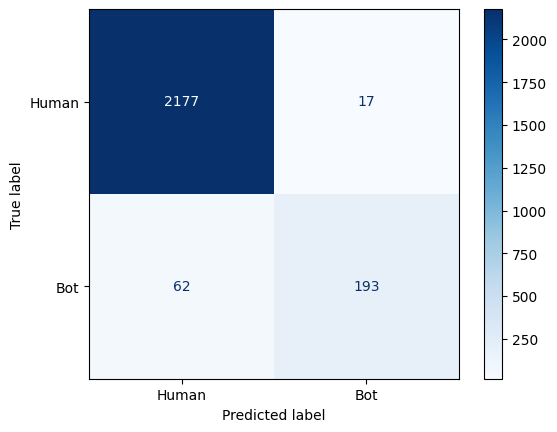

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(best_preds_pd_df["bot"], best_preds_pd_df["prediction"])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "Bot"]).plot(cmap='Blues')

In [86]:
# Saving the model
best_model.write().overwrite().save("/home/ubuntu/PycharmProjects/mmds/model")

---

# Bloom Filter

---